## Prep for fast.ai machine setup

In [3]:
!pip install pathlib
!pip install fastai
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image
%matplotlib inline
from fastai.imports import *

    100% |████████████████████████████████| 51kB 2.3MB/s 
  Running setup.py bdist_wheel for pathlib ... - done
  Stored in directory: /root/.cache/pip/wheels/f9/b2/4a/68efdfe5093638a9918bd1bb734af625526e849487200aa171
Successfully built pathlib
    100% |████████████████████████████████| 122kB 4.2MB/s 
    100% |████████████████████████████████| 112kB 5.5MB/s 
    100% |████████████████████████████████| 3.6MB 954kB/s 
    100% |████████████████████████████████| 2.2MB 11.9MB/s 
    100% |████████████████████████████████| 1.5MB 14.0MB/s 
    100% |████████████████████████████████| 496.4MB 34kB/s 
    100% |████████████████████████████████| 184kB 21.7MB/s 
    100% |████████████████████████████████| 51kB 21.4MB/s 
    100% |████████████████████████████████| 61kB 22.4MB/s 
    100% |████████████████████████████████| 11.6MB 2.6MB/s 
    100% |████████████████████████████████| 901kB 2.5MB/s 
    100% |████████████████████████████████| 71kB 22.6MB/s 
    100% |█████████████████████████████

### Lesson 1: Dogs and Cats

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [7]:
# Get the file from fast.ai URL, unzip it, and put it into the folder 'data'
# This uses -qq to make the unzipping less verbose.
!wget http://files.fast.ai/data/dogscats.zip && unzip -qq dogscats.zip -d data/


Redirecting output to ‘wget-log.1’.


In [10]:
# Check to make sure the data is where you think it is:
!ls

659429ca498b67b5d46e70b80ed0b4a6  dogscats.zip	wget-log
data				  sample_data	wget-log.1


In [11]:
# Check to make sure the folders all unzipped properly:
!ls data/dogscats

models	sample	test1  train  valid


PATH is the path to your data.
sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.

In [0]:
PATH = "data/dogscats/"
sz=224

In [13]:
torch.cuda.is_available()

True

In [14]:
torch.backends.cudnn.enabled

True

In [15]:
os.listdir(PATH)

['sample', 'test1', 'valid', 'train', 'models']

In [16]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [17]:
files = os.listdir(f'{PATH}valid/cats')[:2]
files

['cat.7013.jpg', 'cat.7228.jpg']

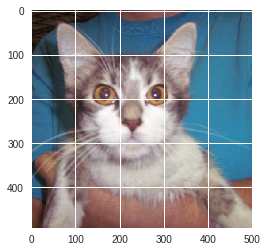

In [20]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [22]:
files = os.listdir(f'{PATH}valid/dogs')[:2]
files

['dog.8317.jpg', 'dog.3222.jpg']

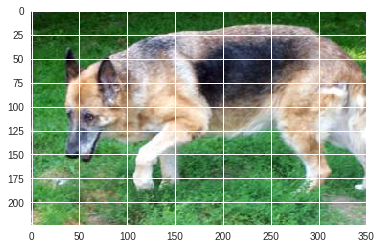

In [24]:
img = plt.imread(f'{PATH}valid/dogs/{files[0]}')
plt.imshow(img);

# Our First Model

In [25]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 53950285.51it/s]


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.053306   0.025831   0.992     
    1      0.036405   0.029087   0.9895    



[array([0.02909]), 0.9895]

# Chosing a Learning Rate

In [0]:
# We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [27]:
lrf=learn.lr_find()

 83%|████████▎ | 299/360 [00:08<00:01, 35.86it/s, loss=0.447]


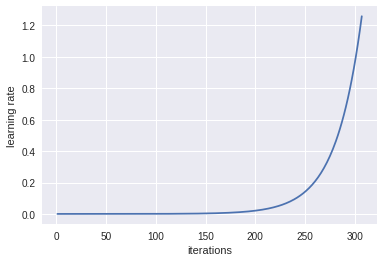

In [28]:
learn.sched.plot_lr()

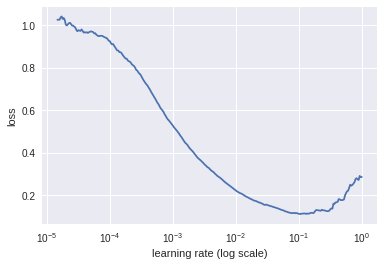

In [29]:
learn.sched.plot()

# Improving our model

In [0]:
# Data Augmentation
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

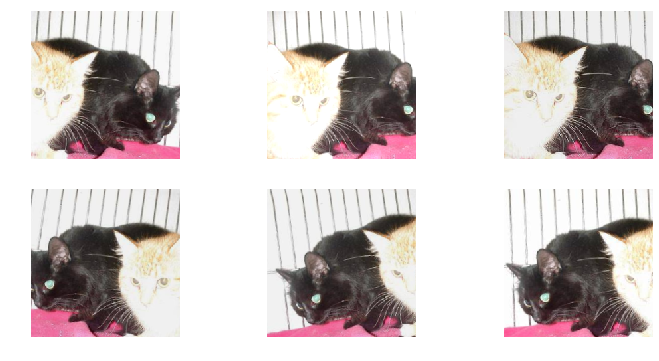

In [34]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [36]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.059403   0.025791   0.991     



[array([0.02579]), 0.991]

In [0]:
learn.precompute=False

In [38]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.046805   0.026172   0.9905    
    1      0.039513   0.025111   0.9915    
    2      0.04345    0.027831   0.989     



[array([0.02783]), 0.989]

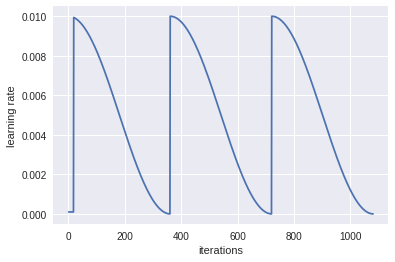

In [39]:
learn.sched.plot_lr()

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [44]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.046088   0.028016   0.99      
    1      0.040292   0.022587   0.992     
    2      0.024848   0.021546   0.9925    
    3      0.041324   0.022254   0.992     
    4      0.022722   0.018982   0.993     
    5      0.024214   0.018263   0.994     
    6      0.015979   0.017935   0.993     



[array([0.01793]), 0.993]

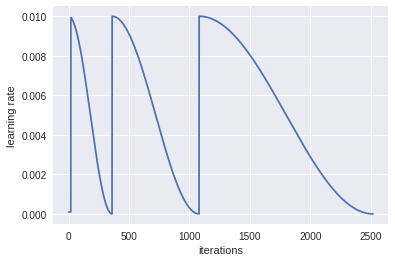

In [45]:
learn.sched.plot_lr()

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

In [48]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [52]:
accuracy_np(probs, y)

0.9935

In [53]:
ls

659429ca498b67b5d46e70b80ed0b4a6  dogscats.zip  sample_data/  wget-log.1
data/                             lr_plot.png   wget-log


In [0]:
learn.save('224_all')

In [55]:
ls

659429ca498b67b5d46e70b80ed0b4a6  dogscats.zip  sample_data/  wget-log.1
data/                             lr_plot.png   wget-log


## Where are the models saved?

./data/dogscats/models

224_all.h5  
224_lastlayer.h5  
tmp.h5



In [58]:
import os
print( os.getcwd() )
print( os.listdir('data') )

/content
['dogscats']


In [0]:
from google.colab import files
files.download("./data/dogscats/models/224_all.h5")

In [62]:
# See if GPU is available

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9833041218859468276, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8140265882
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1026987420874601889
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]